In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt

from tsa.preprocessing import get_sample_info, tpm_normalization, merge_replicates
from tsa.gpr import gpr
from tsa.gene_selection import score_normalization, plot_scores, best_n_genes
from tsa.clustering import cluster_genes
from tsa.alignment import time_series_alignment
from tsa.utils import inference_timeseries, all_numeric

plt.rcParams['figure.figsize'] = [8, 6]

# Input files

In [2]:
# tpm_file = "data/GRCz11-TPM.tsv"
# tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

# template_samples_file = "data/white_mpf_samples.tsv"
# query_samples_file = "data/levin_mpf_samples.tsv"
# # query_samples_file = "data/white_mpf_samples.tsv"  # control
# # query_samples_file = "data/marletaz_mpf_samples.tsv"

# # currently ran for 
# # 18906 genes with min(TPM) > 5 and median(TPM) > 0 (2 ConvergenceWarnings: gene 4096 and 4817)
# # with 171 points (10 per original timepoint)
# new_gpr = False
# gpr_inference_file = "data/white_mpf_gpr.tsv"
# gpr_scores_file = "data/white_mpf_score.tsv"

# showcase_gene = "ENSDARG00000000212"

In [3]:
tpm_file = "data/XT9.1-TPM.tsv"
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

template_samples_file = "data/owensA1_mpf_samples.tsv"
# query_samples_file = "data/owensA1_mpf_samples.tsv"  # control
# query_samples_file = "data/owensA2_mpf_samples.tsv"
# query_samples_file = "data/owensB1_mpf_samples.tsv"
query_samples_file = "data/tanA_mpf_samples.tsv"
# query_samples_file = "data/tanB_mpf_samples.tsv"

new_gpr = False
gpr_inference_file = "data/owensA1_mpf_gpr.tsv"
gpr_scores_file = "data/owensA1_mpf_score.tsv"

showcase_gene = "ENSXETG00000000002"

# Infer expression over time for template genes

In [4]:
# preprocessing
template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
template_sample_order, template_time2samples = get_sample_info(template_samples)

template_tpms = tpm_normalization(tpms, template_sample_order, min_value=5, min_median_value=0, verbose=True)

template_tpms.head(3)

6607 genes with max below 5 TPM (31%)
313 genes with median below or equal to 0 TPM (2%)
14159 genes, 53 samples left after filtering


,GSM1606183,GSM1606184,GSM1606185,GSM1606186,GSM1606187,GSM1606188,GSM1606189,GSM1606190,GSM1606191,GSM1606192,...,GSM1606226,GSM1606227,GSM1606228,GSM1606229,GSM1606230,GSM1606231,GSM1606232,GSM1606233,GSM1606234,GSM1606235
gene,,,,,,,,,,,,,,,,,,,,,
ENSXETG00000000002,6.131145,5.921640,5.998804,6.173674,6.119142,6.259830,6.370552,6.320937,6.400027,6.237597,...,5.490205,5.543036,5.546245,5.679767,5.636308,5.700778,5.943369,5.930271,5.645986,5.643494
ENSXETG00000000003,6.111369,6.290138,6.274922,6.228988,6.207515,6.132275,6.137256,5.965053,5.854107,5.922741,...,5.061129,4.948665,5.032481,4.139545,4.887050,4.604822,3.982709,4.210871,4.935422,4.906007
ENSXETG00000000004,4.212082,4.236750,4.049790,3.841060,3.684565,3.447427,3.320187,3.418296,3.336306,3.648000,...,3.623838,3.655968,3.703871,3.500498,3.397711,3.481193,3.148725,3.249156,3.184631,3.197012


In [5]:
# help(gpr)

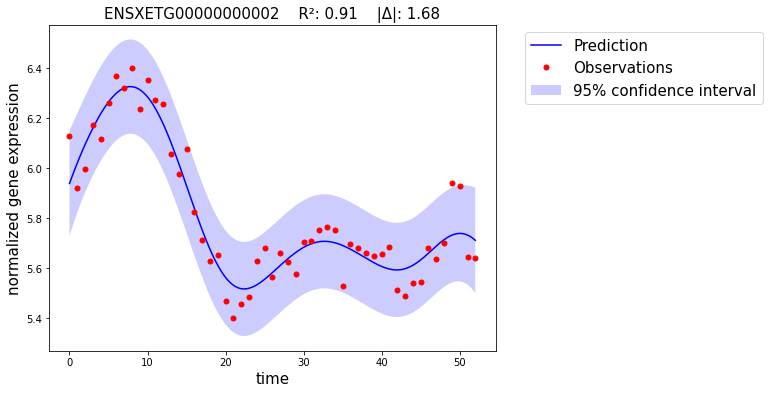

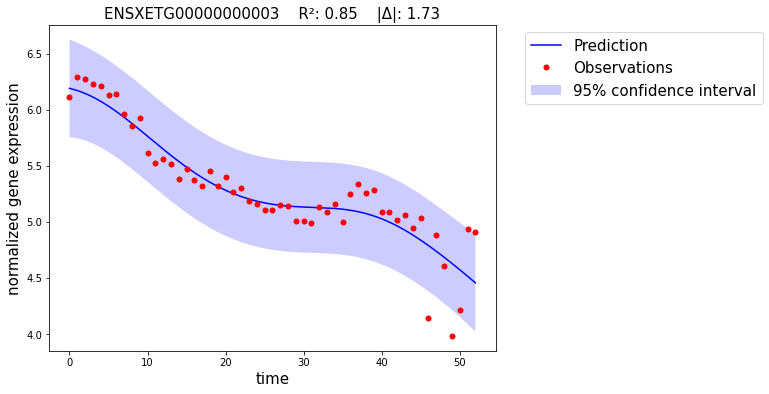

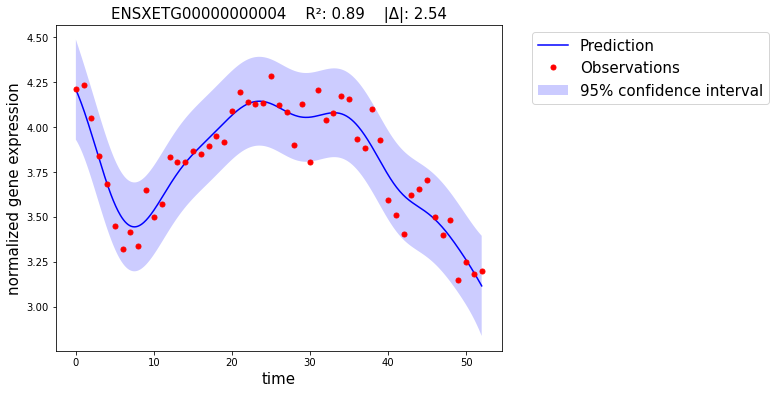

In [6]:
# # linear space
# extended_timepoints = list(np.round(np.linspace(min(time2samples), max(time2samples), 10), 2))

# infer n timepoints for each original timepoint 
timepoints_per_sample = 10
extended_timepoints = inference_timeseries(list(template_time2samples), timepoints_per_sample)

# run 3x with pictures
tmp, _ = gpr(template_time2samples, template_tpms, extended_timepoints, plot=True, verbose=False, run_n=3)

if new_gpr:
    # run with all genes
    template_tpms_inf, gpr_scores = gpr(template_time2samples, template_tpms, extended_timepoints, plot=False, verbose=True, run_n=None)
    
    template_tpms_inf.to_csv(gpr_inference_file, sep="\t")
    gpr_scores.to_csv(gpr_scores_file, sep="\t")
else:
    template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)
    gpr_scores = pd.read_csv(gpr_scores_file, sep="\t", index_col=0)


In [7]:
# when loading a gpr inference table, make sure the rows and columns match the settings
if new_gpr is False:
    gene = tmp.index[0]
    if tmp.index[0] != template_tpms_inf.index[0]:
        raise ValueError("`template_tpms` gene order has changed since creating the template_tpms_inf table")
    if tmp.columns.equals(template_tpms_inf.columns):
        raise ValueError("`extended_timepoints` has changed since creating the template_tpms_inf table")
    print("all good!")

all good!


### Filter template genes by GPR model accuracy (R-squared), expression variability, or both.

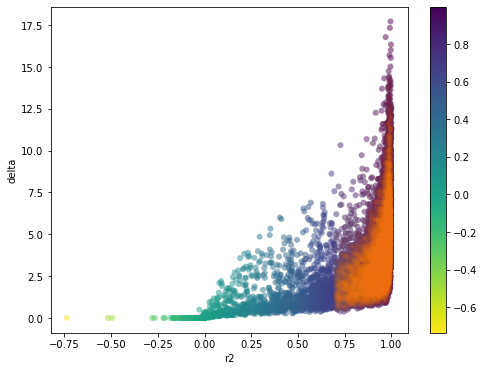

In [8]:
# remove genes that weren't modelled accurately
weight_expr=0
min_r2 = 0.7
weight_r2=1

gpr_scores.dropna(inplace=True)
gpr_normscores = score_normalization(gpr_scores, weight_expr, weight_r2)
top_template_genes = gpr_normscores[gpr_normscores.r2 >= min_r2].index.to_list()
plot_scores(gpr_normscores, highlight_top_n=len(top_template_genes))

# n = 12_000
# top_template_genes = best_n_genes(gpr_normscores, n)
# gpr_normscores = score_normalization(gpr_scores, weight_expr=1, weight_r2=3)
# plot_scores(gpr_normscores, highlight_top_n=n)

# Gene selection

In [9]:
# preprocessing
query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)

target_distribution = template_tpms[template_tpms.columns[0]].to_list()
query_tpms = tpm_normalization(tpms, sample_order, min_value=5, min_median_value=0, qnorm_target_dist=target_distribution)

# TODO: other methods, such as GPR?
query_tpms = merge_replicates(query_tpms, time2samples, how="mean")

if all_numeric(time2samples):
    # convert time to numeric
    samples2time = query_samples.to_dict()["time"]
    query_tpms = query_tpms.rename(columns=samples2time)

query_tpms.head(3)

7831 genes with max below 5 TPM (37%)
351 genes with median below or equal to 0 TPM (2%)
12897 genes, 14 samples left after filtering


,300,390,480,870,900,930,960,1050,1140,1620,1800,1980
gene,,,,,,,,,,,,
ENSXETG00000000002,2.918047,2.939822,2.883835,2.689720,2.677508,2.689112,2.774929,2.756063,2.686906,2.657319,2.690398,2.730381
ENSXETG00000000003,2.521153,2.548008,2.520327,2.428970,2.484983,2.461018,2.336752,2.120366,2.185388,2.387895,2.330331,2.394415
ENSXETG00000000004,2.229224,2.072692,2.140017,2.282417,2.336858,2.246737,2.453404,2.314395,2.112050,2.006436,2.003433,2.062820


In [10]:
# overlap of query genes & top template genes
query_genes = query_tpms.index
starting_genes = set(top_template_genes).intersection(query_genes)

print(len(starting_genes), "overlapping genes")

template_gene_clusters = cluster_genes(template_tpms_inf, starting_genes)

10894 overlapping genes


# TSA

In [11]:
# help(time_series_alignment)

Average TSA of 10 alignments with 20% of genes per cluster 
(36 clusters, 2178 total genes)


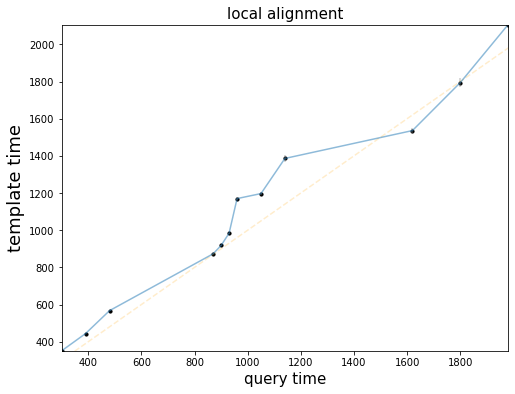

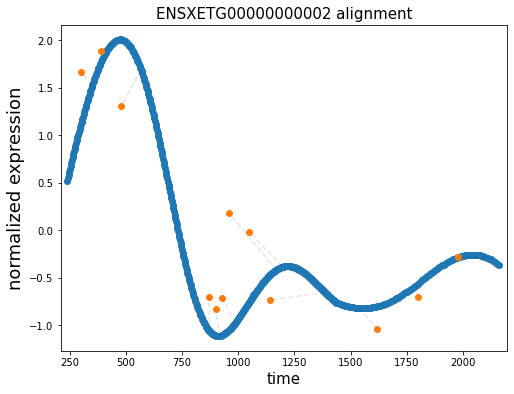

In [12]:
path = time_series_alignment(template_tpms_inf, query_tpms, template_gene_clusters, showcase_gene=showcase_gene)
# paths = time_series_alignment(template_tpms_inf, query_tpms, template_gene_clusters, cycles=3, showcase_gene=showcase_gene)

## Save TSA results

In [13]:
alignment_dir = "alignments"
t_fname = os.path.basename(template_samples_file).replace("_samples.tsv", "")
q_fname = os.path.basename(query_samples_file).replace("_samples.tsv", "")
alignment_file = os.path.join(alignment_dir, f"{t_fname}_to_{q_fname}_alignment.tsv")

query_time = list(time2samples)
mapped = pd.DataFrame(data={
    "annotated_time": time2samples.keys(),
    "inferred_time": [extended_timepoints[i] for i in path],
    "samples": time2samples.values(),
}).set_index("annotated_time")
mapped.to_csv(alignment_file, sep="\t")
print(f"saving mapping in '{alignment_file}'.")

mapped = pd.read_csv(alignment_file, sep="\t", index_col=0)
mapped.head(3)

saving mapping in 'alignments/owensA1_mpf_to_tanA_mpf_alignment.tsv'.


,inferred_time,samples
annotated_time,,
300,351.0,['GSM919922']
390,444.0,['GSM919923']
480,567.0,"['GSM919924', 'GSM919925']"


In [14]:
ok you can stop here

SyntaxError: invalid syntax (3330225663.py, line 1)

In [ ]:
# TSA input files
# tpm_file = "data/GRCz11-TPM.tsv"
# template_samples_file = "data/white_stage_samples.tsv"
# template_samples_file = "data/white_mpf_samples.tsv"
# gpr_inference_file = "data/white_stage_gpr.tsv"
# selected_genes_file = "data/white_stage_selected_genes.tsv"

# query_samples_file = "data/white_stage_samples.tsv"
# query_samples_file = "data/levin_stage_samples.tsv"
# query_samples_file = "data/marletaz_stage_samples.tsv"
# query_samples_file = "data/white_mpf_samples.tsv"
# query_samples_file = "data/levin_mpf_samples.tsv"
# query_samples_file = "data/marletaz_mpf_samples.tsv"

# TSA output files
# alignment_file = "data/white_stage_white_stage_mapping.tsv"
# alignment_file = "data/white_stage_levin_stage_mapping.tsv"
# alignment_file = "data/white_stage_marletaz_stage_mapping.tsv"
# alignment_file = "data/white_mpf_white_mpf_mapping.tsv"
# alignment_file = "data/white_mpf_levin_mpf_mapping.tsv"
# alignment_file = "data/white_mpf_marletaz_mpf_mapping.tsv"
# alignment_file = "data/white_mpf_linear_white_mpf_mapping.tsv"
# alignment_file = "data/white_mpf_linear_levin_mpf_mapping.tsv"
# alignment_file = "data/white_mpf_linear_marletaz_mpf_mapping.tsv"

# query_samples_file = "data/owensA1_mpf_samples.tsv"
# alignment_file = "data/owensA1_mpf_owensA1_mpf_mapping.tsv"

# query_samples_file = "data/owensA2_mpf_samples.tsv"
# alignment_file = "data/owensA1_mpf_owensA2_mpf_mapping.tsv"

# query_samples_file = "data/owensB1_mpf_samples.tsv"
# alignment_file = "data/owensA1_mpf_owensB1_mpf_mapping.tsv"

# query_samples_file = "data/tanA_mpf_samples.tsv"
# alignment_file = "data/owensA1_mpf_tanA_mpf_mapping.tsv"

# query_samples_file = "data/tanB_mpf_samples.tsv"
# alignment_file = "data/owensA1_mpf_tanB_mpf_mapping.tsv"

In [ ]:
# # preprocessing
# query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
# sample_order, time2samples = get_sample_info(query_samples)

# tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)
# query_tpms = tpm_normalization(tpms, sample_order)

# # cost matrix
# # selected_genes = list(pd.read_csv(selected_genes_file, sep="\t")["gene"])
# # template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)
# cost_matrix = get_cost_matrix(template_tpms_inf, query_tpms, selected_genes, time2samples)

# # LTSA
# best_path, best_score = best_alignment_graph(cost_matrix)
# plot_alignment(cost_matrix, best_path)

# # mapping
# query_time = list2floats(query_samples.time.unique())
# extended_template_time = list2floats(template_tpms_inf.columns)
# mapped = pd.DataFrame(data={
#     "original_time": query_time,
#     "inferred_time": [extended_template_time[i] for i in best_path],
# })
# # mapped.to_csv(alignment_file, sep="\t", index=False)  # noqa

In [ ]:
# # preprocessing
# query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
# sample_order, time2samples = get_sample_info(query_samples)

# tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)
# query_tpms = tpm_normalization(tpms, sample_order)
# query_tpms = query_tpms[query_tpms.index.isin(selected_genes)]

In [ ]:
# import seaborn as sns
# from scipy.spatial.distance import cdist

# def get_cost_matrix(template_tpms, query_tpms, metric='euclidean'):
#     template = template_tpms.to_numpy(dtype=np.float64)
#     query = query_tpms.to_numpy(dtype=np.float64)
#     cost_matrix = cdist(template.T, query.T, metric=metric).T  # pairwise distance matrix
#     return cost_matrix

In [ ]:
# query_tpms.shape

In [ ]:
# t = pd.read_csv("data/white_mpf_white_mpf_mapping.tsv", sep="\t")
# q = pd.read_csv("data/white_mpf_levin_mpf_metric_test_mapping.tsv", sep="\t")
# template_tpms_inf = pd.read_csv("data/white_mpf_gpr.tsv", sep="\t", index_col=0)
# extended_template_time = list2floats(template_tpms_inf.columns)

# genes = template_tpms_inf.index.to_list()
# gene = genes[100]

In [ ]:
# metrics = ["braycurtis", "canberra", "chebyshev", "cityblock", "correlation", "cosine", "dice", "euclidean", "hamming", "jaccard", "jensenshannon", "kulsinski", "mahalanobis", "matching", "minkowski", "rogerstanimoto", "russellrao", "seuclidean", "sokalmichener", "sokalsneath", "sqeuclidean", "wminkowski", "yule"]
# metrics = ["braycurtis", "canberra", "chebyshev", "correlation", "cosine", "euclidean", "jensenshannon", "minkowski", "seuclidean", "sqeuclidean"]
# for metric in metrics:
#     print(metric)
#     try:
#         cost_matrix = get_cost_matrix(template_tpms, query_tpms, metric)#='euclidean')
#     except:
#         print("failed")
#         continue

#     # LTSA
#     best_path, best_score = best_alignment_graph(cost_matrix)
#     plot_alignment(cost_matrix, best_path)

#     # heatmap, matrix flipped to go from bottom left to top right.
#     sns.heatmap(cost_matrix[:,::-1].T)
#     plt.show()
    
#     # mapping
#     query_time = list2floats(query_samples.time.unique())
#     extended_template_time = list2floats(template_tpms_inf.columns)
#     mapped = pd.DataFrame(data={
#         "original_time": query_time,
#         "inferred_time": [extended_template_time[i] for i in best_path],
#     })
# #     print(mapped)
#     #mapped.to_csv("data/white_mpf_levin_mpf_metric_test_mapping.tsv", sep="\t", index=False)  # noqa
    
#     # alignment
#     #q = pd.read_csv("data/white_mpf_levin_mpf_metric_test_mapping.tsv", sep="\t")
#     # q = mapped
#     x1 = extended_template_time
#     y1 = template_tpms_inf.loc[gene].to_list()

#     x2 = mapped.original_time.to_list()
#     y2 = query_tpms.loc[gene].to_list() 

#     plt.scatter(x=x1, y=y1)
#     plt.scatter(x=x2, y=y2)
#     for n in range(len(x2)):
#         m = best_path[n]
#         plt.plot((x1[m], x2[n]), (y1[m], y2[n]), color = 'black', alpha=0.1, linestyle='--')

#     # pretty stuff
#     plt.title(f"{gene} alignment")
#     start = x1[best_path[0]]
#     end = max(x1[best_path[-1]], x2[-1])
#     a_bit = (end - start) * 0.05
#     plt.xlim(start - a_bit, end + a_bit)
#     plt.show()

In [ ]:
# t = pd.read_csv("data/white_mpf_white_mpf_mapping.tsv", sep="\t")
# q = pd.read_csv("data/white_mpf_levin_mpf_metric_test_mapping.tsv", sep="\t")
# template_tpms_inf = pd.read_csv("data/white_mpf_gpr.tsv", sep="\t", index_col=0)
# extended_template_time = list2floats(template_tpms_inf.columns)

# genes = template_tpms_inf.index.to_list()
# gene = genes[100]

# # x1 = t.original_time.to_list()
# # y1 = template_tpms.loc[gene].to_list()[::5]  # 5 replciates
# x1 = extended_template_time
# y1 = template_tpms_inf.loc[gene].to_list()

# x2 = q.original_time.to_list()
# y2 = query_tpms.loc[gene].to_list() 

# plt.scatter(x=x1, y=y1)
# plt.scatter(x=x2, y=y2)
# for n in range(len(x2)):
#     m = best_path[n]
#     plt.plot((x1[m], x2[n]), (y1[m], y2[n]), color = 'black', alpha=0.1, linestyle='--')
    
# # pretty stuff
# plt.title(f"{gene} alignment")
# start = x1[best_path[0]]
# end = max(x1[best_path[-1]], x2[-1])
# a_bit = (end - start) * 0.05
# plt.xlim(start - a_bit, end + a_bit)



In [ ]:
# gene = selected_genes[0]
# t = template_tpms_inf.loc[gene]
# q = query_tpms.loc[gene]
# a = [t.to_list()[i] for i in best_path]

# plt.scatter(x=range(len(t)), y=t)
# plt.scatter(x=best_path, y=a)
# plt.scatter(x=best_path, y=q)
# plt.title(f"{gene} alignment")

# for n in range(len(q)):
#     m = best_path[n]
#     plt.plot((m, m), (a[n], q[n]), color = 'black', alpha=0.1, linestyle='--')

# Timeline

In [ ]:
# Timeline input files
# template_samples_file = "data/white_stage_samples.tsv"
# template_samples_file = "data/white_mpf_samples.tsv"
# gpr_inference_file = "data/white_mpf_gpr.tsv"

# alignment_files = {
#     "white": "data/white_stage_white_stage_mapping.tsv",
#     "levin": "data/white_stage_levin_stage_mapping.tsv",
#     "marletaz": "data/white_stage_marletaz_stage_mapping.tsv",
# }
# alignment_files = {
#     "white": "data/white_mpf_white_mpf_mapping.tsv",
#     "levin": "data/white_mpf_levin_mpf_mapping.tsv",
#     "marletaz": "data/white_mpf_marletaz_mpf_mapping.tsv",
# }
# alignment_files = {
#     "white": "data/white_mpf_1000_white_mpf_mapping.tsv",
#     "levin": "data/white_mpf_1000_levin_mpf_mapping.tsv",
#     "marletaz": "data/white_mpf_1000_marletaz_mpf_mapping.tsv",
# }
alignment_files = {
    "owensA1": "data/owensA1_mpf_owensA1_mpf_mapping.tsv",
    "owensA2": "data/owensA1_mpf_owensA2_mpf_mapping.tsv",
    "owensB1": "data/owensA1_mpf_owensB1_mpf_mapping.tsv",
    "tanA": "data/owensA1_mpf_tanA_mpf_mapping.tsv",
    "tanB": "data/owensA1_mpf_tanB_mpf_mapping.tsv",
}

####################################################

# x axis
# template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
# template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)

template_time = list2floats(template_samples.time.unique())
extended_template_time = list2floats(template_tpms_inf.columns)
# extended_timepoints = inference_timeseries(template_time, timepoints_per_sample)
plot_alignments(template_time, extended_template_time, alignment_files)

In [ ]:
samples = pd.read_csv("/bank/experiments/2020-07/s2s_batch_corr2/samples.tsv", sep="\t", index_col=0)

# fix errors in mpf and hpf columns
samples.loc[samples.index == "GSM919943", "mpf"] = 240
samples.loc[samples.index == "GSM919943", "hpf"] = 4.0

samples.loc[samples.index == "GSM919944", "mpf"] = 300
samples.loc[samples.index == "GSM919944", "hpf"] = 5.0

samples.loc[samples.index == "GSM919922", "mpf"] = 300
samples.loc[samples.index == "GSM919922", "hpf"] = 5.0

df = samples[samples["batch"] == 'owens_clutchA_polyA_run1']
df = df[["stage", "mpf"]].reset_index(drop=True)
df = df.sort_values("mpf", ascending=True)

stage2time = {}
for stage in df.stage.unique():
    stage2time[stage] = df[df["stage"] == stage]["mpf"].mean()
    
list(stage2time.values())

FileNotFoundError: [Errno 2] No such file or directory: 'data/owensA1_mpf_owensA1_mpf_mapping.tsv'

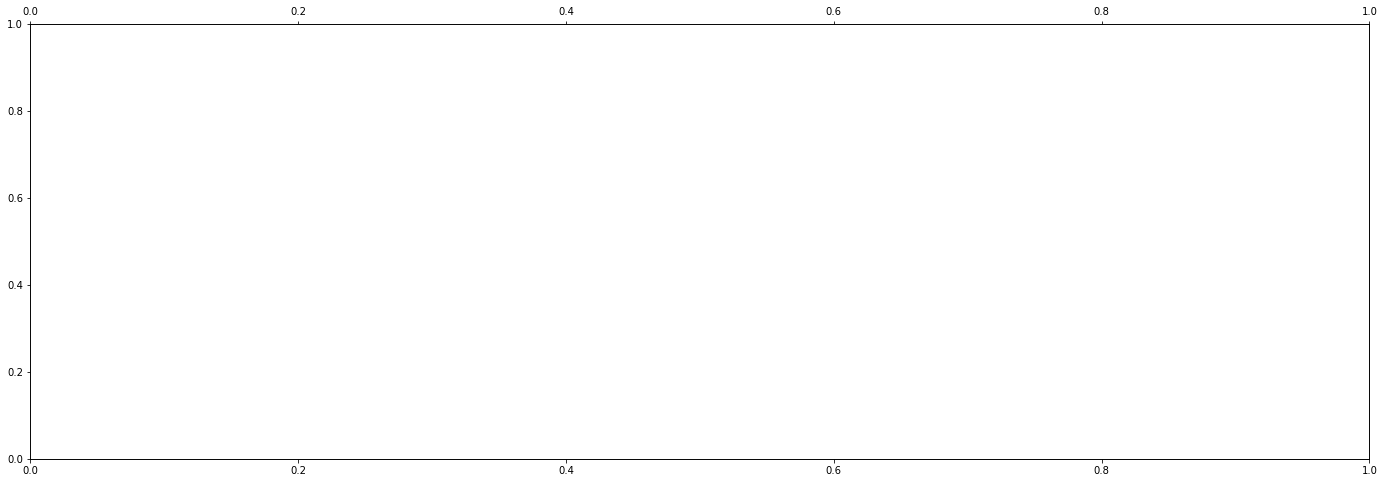

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# xenopus timeline (OwensA1 (with average time per stage))
all_mpf = [
    240.0,
    315.0,
    420.0,
    480.0,
    555.0,
    660.0,
    750.0,
    825.0,
    870.0,
    900.0,
    930.0,
    960.0,
    1005.0,
    1065.0,
    1110.0,
    1185.0,
    1290.0,
    1380.0,
    1500.0,
    1650.0,
    1740.0,
    1800.0,
    1890.0,
    2040.0,
    2160.0,
]
all_stages = [
    'stage8',
    'stage9',
    'stage10',
    'stage11',
    'stage12',
    'stage12.5',
    'stage13',
    'stage14',
    'stage15',
    'stage17',
    'stage19',
    'stage20',
    'stage21',
    'stage22',
    'stage23',
    'stage24',
    'stage25',
    'stage26',
    'stage27',
    'stage28',
    'stage30',
    'stage31',
    'stage32',
    'stage34',
    'stage35',
]

#########################################

# query alignments
alignment_files = {
    "owensA1": "data/owensA1_mpf_owensA1_mpf_mapping.tsv",
    "owensA2": "data/owensA1_mpf_owensA2_mpf_mapping.tsv",
    "owensB1": "data/owensA1_mpf_owensB1_mpf_mapping.tsv",
    "tanA": "data/owensA1_mpf_tanA_mpf_mapping.tsv",
    "tanB": "data/owensA1_mpf_tanB_mpf_mapping.tsv",
}

# output plot
plot_file = "data/alignment_owensA1_mpf.pdf"

#########################################

plt.rcParams['figure.figsize'] = [24, 8]
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

n = 0
ylabels = []
for series in alignment_files:
    df = pd.read_csv(alignment_files[series], sep="\t")
    x1 = df["original_time"]
    x2 = df["inferred_time"]
    plt.scatter(x=x1, y=np.zeros_like(x1) + n)
    n += 1
    plt.scatter(x=x2, y=np.zeros_like(x2) + n)
    n += 1
    ylabels.extend([f"{series} annotated", f"{series} inferred"])
    
    matches = zip(x1, x2)
    for i, j in matches:
        plt.plot((i, j), (n-2, n-1), color = 'black', alpha=0.1, linestyle='--')

# plot shape
x_axis = all_mpf
x_labels1 = all_stages
x_labels2 = all_mpf

x_range = max(x_axis) - min(x_axis)
plt.yticks(list(range(n)), ylabels)
plt.ylim(-0.5, n - 0.5)
plt.ylabel("time series")

total_time = max(x_axis) - min(x_axis)
plt.xlim(min(x_axis) - x_range * 0.03, max(x_axis) + x_range * 0.03)
ax1.set_xlim(ax2.get_xlim())  # for some reason ax2 has the limits we need, but not ax1(?)
# ax1.grid(True, "major", axis="x", alpha=0.7,ls=':',)

ax1.set_xticks(x_axis)
ax1.set_xticklabels(x_labels1, rotation=45, ha="right")
ax1.set_xlabel("developmental stage")

ax2.set_xticks(x_axis)
ax2.set_xticklabels(x_labels2, rotation=45, ha="left")
ax2.set_xlabel("minutes post fertilization")

plt.savefig(plot_file)
plt.show()

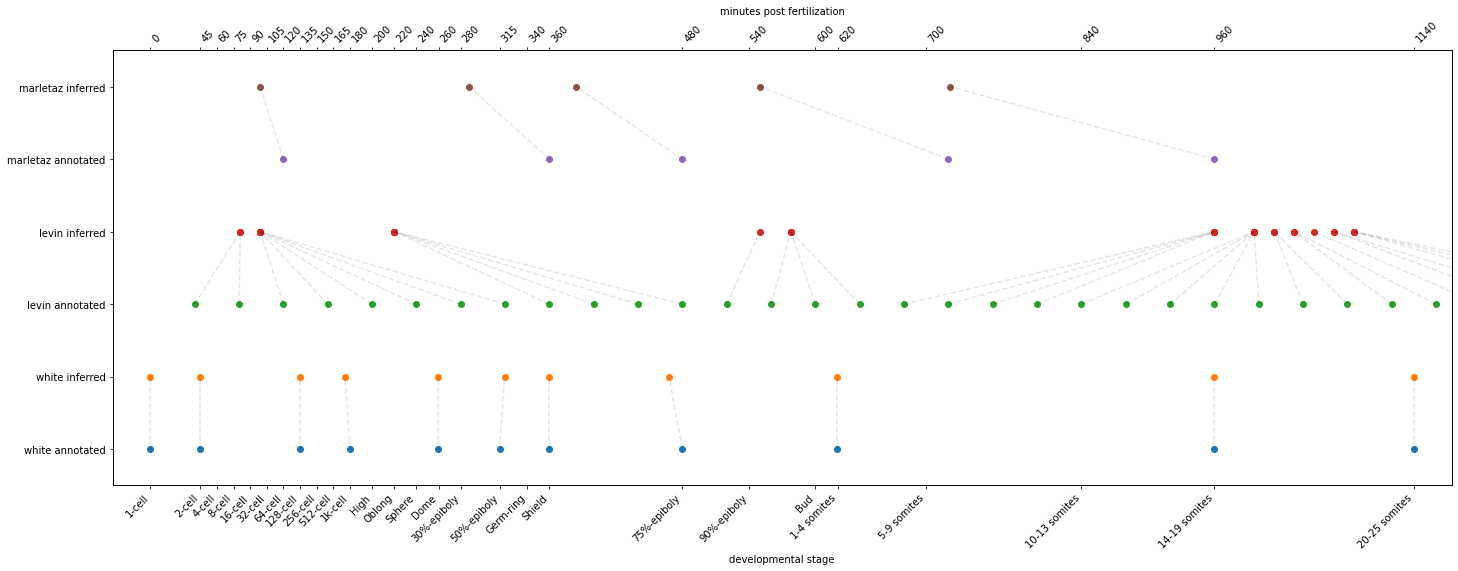

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsa.utils import inference_timeseries


# universal zebrafish time axis (from ZFIN)
all_mpf = [
    0,
    45,
    60,
    75,
    90,
    105,
    120,
    135,
    150,
    165,
    180,
    200,
    220,
    240,
    260,
    280,
    315,
    340,
    360,
    480,
    540,
    600,
    620,
    700,
    840,
    960,
    1140,
    1320,
    1440,
    1800,
    2160,
    2520,
    2880,
    3600,
    4320,
    5760,
    7200,
    8640,
    10080,
    20160,
    30240,
    43200,
    64800,
][:-6]
all_stages = [
    "1-cell",
    "2-cell",
    "4-cell",
    "8-cell",
    "16-cell",
    "32-cell",
    "64-cell",
    "128-cell",
    "256-cell",
    "512-cell",
    "1k-cell",
    "High",
    "Oblong",
    "Sphere",
    "Dome",
    "30%-epiboly",
    "50%-epiboly",
    "Germ-ring",
    "Shield",
    "75%-epiboly",
    "90%-epiboly",
    "Bud",
    "1-4 somites",
    "5-9 somites",
    "10-13 somites",
    "14-19 somites",
    "20-25 somites",
    "26+ somites",
    "Prim-5",
    "Prim-15",
    "Prim-25",
    "High-pec",
    "Long-pec",
    "Pec-fin",
    "Protruding-mouth",
    "Day 4",
    "Day 5",
    "Day 6",
    "Days 7-13",
    "Days 14-20",
    "Days 21-29",
    "Days 30-44",
    "Days 45-89",
][:-6]


#########################################


# query alignments
# alignment_files = {
#     "white": "data/white_stage_white_stage_mapping.tsv",
#     "levin": "data/white_stage_levin_stage_mapping.tsv",
#     "marletaz": "data/white_stage_marletaz_stage_mapping.tsv",
# }
alignment_files = {
    "white": "data/white_mpf_white_mpf_mapping.tsv",
    "levin": "data/white_mpf_levin_mpf_mapping.tsv",
    "marletaz": "data/white_mpf_marletaz_mpf_mapping.tsv",
}
# alignment_files = {
#     "white": "data/white_mpf_linear_white_mpf_mapping.tsv",
#     "levin": "data/white_mpf_linear_levin_mpf_mapping.tsv",
#     "marletaz": "data/white_mpf_linear_marletaz_mpf_mapping.tsv",
# }

# output plot
plot_file = "data/alignment_white_mpf.pdf"

fig = plt.figure(1,figsize = [24, 8])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

n = 0
ylabels = []
for series in alignment_files:
    df = pd.read_csv(alignment_files[series], sep="\t")
    x1 = df["original_time"]
    x2 = df["inferred_time"]
    plt.scatter(x=x1, y=np.zeros_like(x1) + n)
    n += 1
    plt.scatter(x=x2, y=np.zeros_like(x2) + n)
    n += 1
    ylabels.extend([f"{series} annotated", f"{series} inferred"])
    
    matches = zip(x1, x2)
    for i, j in matches:
        plt.plot((i, j), (n-2, n-1), color = 'black', alpha=0.1, linestyle='--')

# plot shape
x_axis = all_mpf[:-10]
x_labels1 = all_stages[:-10]
x_labels2 = all_mpf[:-10]
x_range = max(x_axis) - min(x_axis)
plt.yticks(list(range(n)), ylabels)
plt.ylim(-0.5, n - 0.5)
plt.ylabel("time series")

total_time = max(x_axis) - min(x_axis)
plt.xlim(min(x_axis) - x_range * 0.03, max(x_axis) + x_range * 0.03)
ax1.set_xlim(ax2.get_xlim())  # for some reason ax2 has the limits we need, but not ax1(?)

ax1.set_xticks(x_axis)
ax1.set_xticklabels(x_labels1, rotation=45, ha="right")
ax1.set_xlabel("developmental stage")

ax2.set_xticks(x_axis)
ax2.set_xticklabels(x_labels2, rotation=45, ha="left")
ax2.set_xlabel("minutes post fertilization")

plt.savefig(plot_file)
plt.show()

In [ ]:
print(ax1.get_xlim())
print(ax2.get_xlim())

In [ ]:
# # template time
# template_samples_file = "data/white_stage_samples.tsv"
# timepoints_per_sample = 10

# # query alignments
# alignments = {
#     "white": "data/white_stage_white_stage_mapping.tsv",
#     "levin": "data/white_stage_levin_stage_mapping.tsv",
#     "marletaz": "data/white_stage_marletaz_stage_mapping.tsv",
# }

# # output plot
# plot_file = "data/alignment_white_stage.pdf"



# template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
# template_time = list(template_samples.time.unique())
# extended_template_time = inference_timeseries(template_time, timepoints_per_sample)

# ext_time_axis = pd.DataFrame({
#     "ext_all_mpf": inference_timeseries(all_mpf, timepoints_per_sample),
#     "ext_all_stages": inference_timeseries(all_stages, timepoints_per_sample),
# })

# plt.rcParams['figure.figsize'] = [24, 8]
# fig = plt.figure(1)
# ax1 = fig.add_subplot(111)
# ax2 = ax1.twiny()

# n = 0
# ylabels = []
# for series in alignments:
#     df = pd.read_csv(alignments[series], sep="\t")

#     x1 = df["original_time"]
#     if df["original_time"].dtype == "O":
#         cv = ext_time_axis.merge(df, left_on="ext_all_stages", right_on="original_time", how="right")
#         x1 = cv["ext_all_mpf"].to_list()
#     plt.scatter(x=x1, y=np.zeros_like(x1) + n)
#     n += 1

#     x2 = df["inferred_time"]
#     if df["inferred_time"].dtype == "O":
#         cv = ext_time_axis.merge(df, left_on="ext_all_stages", right_on="inferred_time", how="right")
#         x2 = cv["ext_all_mpf"].to_list()
#     plt.scatter(x=x2, y=np.zeros_like(x2) + n)
#     n += 1
#     ylabels.extend([f"{series} annotated", f"{series} inferred"])

# # plot shape
# x_axis = all_mpf[:-2]
# x_labels1 = all_stages[:-2]
# x_labels2 = all_mpf[:-2]
# x_range = max(x_axis) - min(x_axis)
# plt.yticks(list(range(n)), ylabels)
# plt.ylim(-0.5, n - 0.5)
# plt.ylabel("time series")

# # total_time = max(x_axis) - min(x_axis)
# # plt.xlim(min(x_axis), max(x_axis))
# plt.xlim(min(x_axis) - x_range * 0.03, max(x_axis) + x_range * 0.03)
# # plt.ylim(-0.5, 2.5)

# ax1.set_xticks(x_axis)
# ax1.set_xticklabels(x_labels1, rotation=45, ha="right")
# ax1.set_xlabel("developmental stage")

# ax2.set_xticks(x_axis)
# ax2.set_xticklabels(x_labels2, rotation=45, ha="left")
# ax2.set_xlabel("minutes post fertilization")

# plt.savefig(plot_file)
# plt.show()